# Pankreopriver diabetes mellitus vs Diabetes Type 1 

### Libraries

In [1]:
# pd.options.display.max_columns= 999

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [5]:
from skbio.stats.ordination import pcoa

### Data loading

In [6]:
df = pd.read_csv(
    "/data/projects/2024/Effenberger-Diabetes/data/PDM merged 3.0_modified.csv"
)

In [7]:
sample_info = pd.read_csv(
    "/data/projects/2024/Effenberger-Diabetes/data/20011/20011_SampleInfo.csv"
)

In [8]:
df.rename(columns={"Probennummer": "sample_information"}, inplace=True)

In [9]:
sample_info.rename(columns={"SampleInformation": "sample_information"}, inplace=True)

In [10]:
df = df.merge(
    sample_info[["sample_information", "IMGM ID", "Type"]],
    on="sample_information",
    how="left",
)

In [11]:
# Load the dataset
file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/barplot/level-6.csv"
df_tax = pd.read_csv(file_path)

In [12]:
df_tax.set_index("index", inplace=True)

In [13]:
exclude_cols = [
    'sample_information', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
    'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
    'BMI1', 'BMI2', 'Pankreatektomie', 'HbA1C_diff', 'Glukose_diff',
    'BMI_diff', 'KHK_diff', 'CA_diff'
]

df_tax_bacteria = df_tax.drop(columns=exclude_cols, errors='ignore')

threshold = 0.1

mean_abundance = df_tax_bacteria.mean(axis=0)

low_abundance_taxa = mean_abundance[mean_abundance < threshold].index

df_low_abundance = df_tax_bacteria[low_abundance_taxa]

high_abundance_taxa = mean_abundance[mean_abundance >= threshold].index

df_high_abundance = df_tax_bacteria[high_abundance_taxa]

In [14]:
#file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/diversity/alpha_diversity/shannon_vector/metadata.tsv"
file_path = "/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/metadata_shannon.tsv"
shannon_entropy = pd.read_csv(file_path, sep="\t")
shannon_entropy = shannon_entropy.iloc[1:]

### Data cleaning

#### Metadata contains clinical information

In [15]:
metadata_cols = df[
    [
        "IMGM ID",
        "sample_information",
        "Type",
        "age",
        "KHK1",
        "KHK2",
        "CA1",
        "CA2",
        "HbA1C (DCCT/NGSP)1",
        "HbA1C (DCCT/NGSP)2",
        "Glukose1",
        "Glukose2",
        "BMI1",
        "BMI2",
       "Pankreatektomie",'sex','Insulin1','Insulin2', 'MASLD1','MASLD2', 'nikotin',
    ]
]

In [16]:
metadata = metadata_cols.dropna(subset=["IMGM ID"])

In [17]:
metadata["HbA1C_diff"] = metadata.apply(
    lambda x: (
        "increase"
        if x["HbA1C (DCCT/NGSP)2"] - x["HbA1C (DCCT/NGSP)1"] > 0
        else "decrease"
    ),
    axis=1,
)
metadata["Glukose_diff"] = metadata.apply(
    lambda x: "increase" if x["Glukose2"] - x["Glukose1"] > 0 else "decrease", axis=1
)
metadata["BMI_diff"] = metadata.apply(
    lambda x: "increase" if x["BMI2"] - x["BMI1"] > 0 else "decrease", axis=1
)

In [18]:
def categorize_diff(before, after):
    if after == "ja" and before == "nein":
        return "onset"
    elif after == "nein" and before == "nein":
        return "absent"
    elif after == "nein" and before == "ja":
        return "resolved"
    elif after == "ja" and before == "ja":
        return "persistent"
    else:
        return "unknown" 


metadata["KHK_diff"] = metadata.apply(
    lambda x: categorize_diff(x["KHK1"], x["KHK2"]), axis=1
)
metadata["CA_diff"] = metadata.apply(
    lambda x: categorize_diff(x["CA1"], x["CA2"]), axis=1
)

In [19]:
metadata.rename(columns={"IMGM ID": "id"}, inplace=True)

In [20]:

metadata_k = metadata[metadata["sample_information"].str.contains("K", na=False)]
metadata_dm = metadata[metadata["sample_information"].str.match("DM", na=False)]
metadata_pdm = metadata[metadata["sample_information"].str.contains("PDM", na=False)]

In [21]:
metadata_k = metadata_k.drop_duplicates(subset=["id"], keep="first")
metadata_dm = metadata_dm.drop_duplicates(subset=["id"], keep="first")
metadata_pdm = metadata_pdm.drop_duplicates(subset=["id"], keep="first")

In [22]:
metadata = metadata.drop_duplicates(subset=["id"], keep="first")

#### Microbial data contains taxonomic information from QUIIME

In [23]:
microbial_data = df_high_abundance.drop(columns=metadata_cols, errors="ignore")

In [24]:
microbial_data["id"] = microbial_data.index

In [25]:
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(";")[-1].strip()

In [26]:
microbial_data.rename(
    columns={col: extract_species_name(col) for col in microbial_data.columns},
    inplace=True,
)

In [27]:
microbial_data.rename(columns={"index": "id"}, inplace=True)

In [28]:
microbial_data.columns = microbial_data.columns.str.strip()
metadata.columns = metadata.columns.str.strip()

print("microbial_data columns:", microbial_data.columns)
print("metadata columns:", metadata.columns)

if "id" in microbial_data.columns and "id" in metadata.columns:
    microbial_data = microbial_data.merge(
        metadata[["id", "Type", "sample_information","age",'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2','Pankreatektomie',
       'BMI1', 'BMI2']], on="id", how="left"
    )
    

else:
    print("'id' column not found in one or both DataFrames.")

microbial_data columns: Index(['', '', '', 'Bacteroides', 'Fusicatenibacter', 'Ruminococcus',
       'Subdoligranulum', 'Prevotella_9', '', '',
       ...
       'Aeromonas', 'CHKCI001', 'DNF00809', 'Succiniclasticum', 'Anaerococcus',
       '', 'Caproiciproducens', '', 'Lachnospiraceae UCG-009', 'id'],
      dtype='object', length=354)
metadata columns: Index(['id', 'sample_information', 'Type', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
       'BMI1', 'BMI2', 'Pankreatektomie', 'sex', 'Insulin1', 'Insulin2',
       'MASLD1', 'MASLD2', 'nikotin', 'HbA1C_diff', 'Glukose_diff', 'BMI_diff',
       'KHK_diff', 'CA_diff'],
      dtype='object')


In [29]:
ordinal_map = {
    "nein": 0,
    "Teilresektion links": 1,
    "Teilresektion rechts": 2,
    "Resektion": 3
}

microbial_data["Pankreatektomie_encoded"] = microbial_data["Pankreatektomie"].map(ordinal_map)

In [30]:
microbial_data_original = microbial_data.copy()

In [31]:
microbial_data = microbial_data.drop(columns=['Pankreatektomie'])

#### Boxplot - Alpha diversity - Shannon entropy

In [32]:
shannon_entropy = shannon_entropy.merge(
    metadata[["id", "Type", "sample_information"]], on="id", how="left"
)

In [33]:
shannon_entropy.head()

,id,KHK1,KHK2,CA1,CA2,Pankreatektomie,HbA1C_diff,Glukose_diff,BMI_diff,KHK_diff,CA_diff,shannon_entropy,Type,sample_information
0,s20011_0048,ja,nein,ja,ja,Teilresektion rechts,increase,increase,increase,resolved,persistent,7.57977458353132,pankreopriver Diabetes,PDM12
1,s20011_0023,ja,ja,ja,ja,nein,decrease,decrease,decrease,persistent,persistent,5.76206650928764,pankreopriver Diabetes,PDM17
2,s20011_0019,nein,nein,nein,nein,nein,decrease,decrease,increase,absent,absent,5.90108494358752,Diabetes mellitus Typ1,DM4
3,s20011_0002,ja,ja,nein,nein,nein,increase,decrease,increase,persistent,absent,5.92288227633451,pankreopriver Diabetes,PDM1
4,s20011_0007,ja,ja,nein,nein,nein,decrease,increase,decrease,persistent,absent,6.16695450601612,pankreopriver Diabetes,PDM2


In [34]:
shannon_entropy["Type"].replace("Diabetes mellitus Typ1", "DM", inplace=True)
shannon_entropy["Type"].replace("pankreopriver Diabetes", "PDM", inplace=True)

/tmp/ipykernel_3559489/2786416197.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  shannon_entropy["Type"].replace("Diabetes mellitus Typ1", "DM", inplace=True)
/tmp/ipykernel_3559489/2786416197.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col]

In [35]:
shannon_entropy["Type"] = shannon_entropy["Type"].replace({"Kontrolle": "K"})

K
DM
K
PDM
PDM
DM


/tmp/ipykernel_3559489/2984200073.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


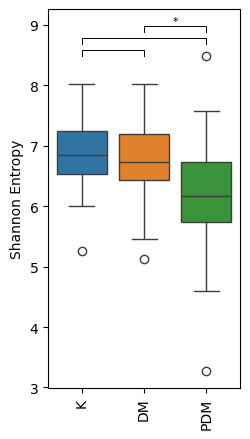

[0.6880901161436235, 0.09256436227426171, 0.04589761917210571]


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pandas as pd

order = ["K", "DM", "PDM"]
custom_palette = {
    "K": "#1f77b4",
    "DM": "#ff7f0e",
    "PDM": "#2ca02c",
}

df_clean = shannon_entropy[
    pd.to_numeric(shannon_entropy["shannon_entropy"], errors="coerce").notnull()
].copy()
df_clean["shannon_entropy"] = df_clean["shannon_entropy"].astype(float)

plt.figure(figsize=(2.6, 4.5))
ax = sns.boxplot(
    data=df_clean, x="Type", y="shannon_entropy", palette=custom_palette, order=order
)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Shannon Entropy")

comparisons = [("K", "DM"), ("K", "PDM"), ("PDM", "DM")]
p_values = []

for group1, group2 in comparisons:
    y1 = df_clean[df_clean["Type"] == group1]["shannon_entropy"]
    y2 = df_clean[df_clean["Type"] == group2]["shannon_entropy"]
    stat, p = mannwhitneyu(y1, y2, alternative="two-sided")
    print(group1)
    print(group2)
    p_values.append(p)

#padj = multipletests(p_values, method='fdr_bh')[1]


y_max = df_clean["shannon_entropy"].max()
h = 0.2  
for i, ((group1, group2), p) in enumerate(zip(comparisons, p_values)):
    x1, x2 = order.index(group1), order.index(group2)

   
    if p < 0.001:
        label = "***"
    elif p < 0.01:
        label = "**"
    elif p < 0.05:
        label = "*"
    else:
        label = ""

   
    y_line = y_max + h * i
    ax.plot(
        [x1, x1, x2, x2],
        [y_line, y_line + 0.1, y_line + 0.1, y_line],
        lw=0.7,
        c="black",
    )
    ax.text((x1 + x2) / 2, y_line + 0.1, label, ha="center", va="bottom", fontsize=8)

plt.tight_layout()

#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/alpha_shannon_pvalue.svg")
#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/alpha_shannon_pvalue.png")
plt.show()
print(p_values)

In [37]:
p_values

[0.6880901161436235, 0.09256436227426171, 0.04589761917210571]

In [38]:
#df_clean.to_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/supplementary_tables/alpha_shannon_pvalue.csv")

#### Boxplot - Alpha diversity - Simpson diversity

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#simpson = pd.read_csv('/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/abundance_tables/exported_simpson/alpha-diversity.tsv', sep='\t', index_col=0)
simpson = pd.read_csv('/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/simpson-alpha-diversity.tsv', sep='\t', index_col=0)



In [40]:
simpson.index.name = 'sample_information'

In [41]:
simpson["id"] = simpson.index

In [42]:
merged = pd.merge(simpson, metadata[['id', 'Type']], on='id')

In [43]:
merged["Type"].replace("Diabetes mellitus Typ1", "DM",inplace=True)
merged["Type"].replace("pankreopriver Diabetes", "PDM",inplace=True)
merged["Type"].replace("Kontrolle","K",inplace=True)
merged["Type"].replace("Diabetes mellitus Typ1", "DM",inplace=True)
merged["Type"].replace("pankreopriver Diabetes", "PDM",inplace=True)
merged["Type"].replace("Kontrolle","K",inplace=True)

/tmp/ipykernel_3559489/3507906541.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["Type"].replace("Diabetes mellitus Typ1", "DM",inplace=True)
/tmp/ipykernel_3559489/3507906541.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(va

/tmp/ipykernel_3559489/1134426433.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


H
T1DM
H
T3cDM
T3cDM
T1DM


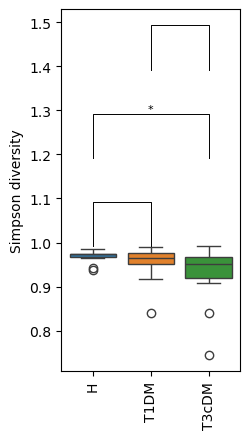

[0.6880901161436235, 0.09256436227426171, 0.04589761917210571, 0.43435111514533487, 0.022339883486320666, 0.06873060061756658]


In [44]:
order = ["H", "T1DM", "T3cDM"]
custom_palette = {
    "H": "#1f77b4",
    "T1DM": "#ff7f0e",
    "T3cDM": "#2ca02c",
}

merged["Type"] = merged["Type"].replace({
    "K": "H",
    "DM": "T1DM",
    "PDM": "T3cDM"
})

plt.figure(figsize=(2.6, 4.5))
ax = sns.boxplot(
    data=merged, x="Type", y="simpsons", palette=custom_palette, order=order
)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Simpson diversity")

comparisons = [("H", "T1DM"), ("H", "T3cDM"), ("T3cDM", "T1DM")]
y_max = merged["simpsons"].max()
h = 0.2  

for i, (group1, group2) in enumerate(comparisons):
    x1, x2 = order.index(group1), order.index(group2)
    y1 = merged[merged["Type"] == group1]["simpsons"]
    y2 = merged[merged["Type"] == group2]["simpsons"]

    stat, p = mannwhitneyu(y1, y2, alternative="two-sided")
    print(group1)
    print(group2)
    p_values.append(p)

    if p < 0.001:
        star =  "***"
    elif p < 0.01:
        star =  "**"
    elif p < 0.05:
        star = "*"
    else:
        star =  ""

    y_line = y_max + h * i
    ax.plot(
        [x1, x1, x2, x2],
        [y_line, y_line + 0.1, y_line + 0.1, y_line],
        lw=0.7,
        c="black",
    )
    ax.text((x1 + x2) / 2, y_line + 0.1, star, ha="center", va="bottom", fontsize=8)


#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/alpha_simpson_pvalue.svg")
#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/alpha_simpson_pvalue.png")

plt.tight_layout()
plt.show()
print(p_values)

In [45]:
#merged.to_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/supplementary_tables/alpha_simpson_pvalue.csv")

#### Boxplot - Alpha diversity - Chao1 index

In [46]:
import pandas as pd
from skbio.diversity.alpha import chao1

In [47]:
#otu_table = pd.read_csv("/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/dada2/ASV_table.tsv", sep = "\t")
otu_table = pd.read_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/ASV_table.tsv", sep = "\t")

In [48]:
otu_table.set_index("ASV_ID", inplace = True)

In [49]:
otu_table = otu_table.T

In [50]:
chao1_df = otu_table.apply(chao1, axis=1)

In [51]:
chao1_df = pd.DataFrame({
    "id": chao1_df.index,
    "chao1": chao1_df.values,
})

In [52]:
df_clean = chao1_df[
    pd.to_numeric(chao1_df["chao1"], errors="coerce").notnull()
].copy()

In [53]:
df_clean["chao1"] = df_clean["chao1"].astype(float)


In [54]:
order = ["K", "DM", "PDM"]
custom_palette = {
    "K": "#1f77b4",
    "DM": "#ff7f0e",
    "PDM": "#2ca02c",
}

In [55]:
df_clean = df_clean.merge(
    microbial_data[["id", "Type"]],
    on="id",
    how="left"
)


In [56]:
df_clean["Type"] = df_clean["Type"].replace(
    {"pankreopriver Diabetes": "PDM", "Diabetes mellitus Typ1": "DM", "Kontrolle": "K"}
)


H
T1DM
H
T3cDM
T3cDM
T1DM


/tmp/ipykernel_3559489/1033119992.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


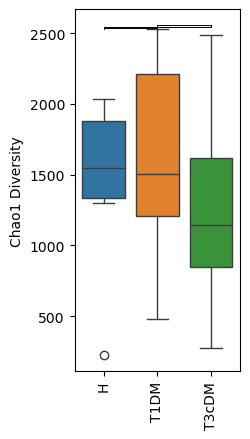

[0.6880901161436235, 0.09256436227426171, 0.04589761917210571, 0.43435111514533487, 0.022339883486320666, 0.06873060061756658, 0.7512945586546257, 0.2380293908461294, 0.11289279116504015]


In [57]:
order = ["H", "T1DM", "T3cDM"]
custom_palette = {
    "H": "#1f77b4",
    "T1DM": "#ff7f0e",
    "T3cDM": "#2ca02c",
}


df_clean["Type"] = df_clean["Type"].replace({
    "K": "H",
    "DM": "T1DM",
    "PDM": "T3cDM"
})

plt.figure(figsize=(2.6, 4.5))

ax = sns.boxplot(
    data=df_clean, x="Type", y="chao1", palette=custom_palette, order=order
)
plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("Chao1 Diversity")


comparisons = [("H", "T1DM"), ("H", "T3cDM"), ("T3cDM", "T1DM")]
y_max = df_clean["chao1"].max()
h = 10  

for i, (group1, group2) in enumerate(comparisons):
    x1, x2 = order.index(group1), order.index(group2)
    y1 = df_clean[df_clean["Type"] == group1]["chao1"]
    y2 = df_clean[df_clean["Type"] == group2]["chao1"]

    stat, p = mannwhitneyu(y1, y2, alternative="two-sided")
    print(group1)
    print(group2)
    p_values.append(p)


  
    if p < 0.001:
        star = "***"
    elif p < 0.01:
        star = "**"
    elif p < 0.05:
        star = "*"
    else:
        star = ""

    
    y_line = y_max + h * i
    ax.plot([x1, x1, x2, x2], [y_line, y_line + 2, y_line + 2, y_line], lw=0.7, c="black")
    ax.text((x1 + x2) / 2, y_line + 2.5, star, ha="center", va="bottom", fontsize=8)

plt.tight_layout()

#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/alpha_chao1_pvalue.svg")
#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/alpha_chao1_pvalue.svg")
plt.show()
print(p_values)

In [58]:
#df_clean.to_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/supplementary_tables/alpha_chao1_pvalue.csv")

In [64]:
metrics = ["Shannon"] * 3 + ["Simpson"] * 3 + ["Chao1"] * 3
comparisons = ["H_vs_T1DM", "H_vs_T3cDM", "T3cDM_vs_T1DM"] * 3
test = ["mannwhitneyu two-sided"]*9

# Create the DataFrame
df = pd.DataFrame({
    "Metric": metrics,
    "Comparison": comparisons,
    "P_value": p_values,
    "test": test
})

In [65]:
df

,Metric,Comparison,P_value,test
0,Shannon,H_vs_T1DM,0.688090,mannwhitneyu two-sided
1,Shannon,H_vs_T3cDM,0.092564,mannwhitneyu two-sided
2,Shannon,T3cDM_vs_T1DM,0.045898,mannwhitneyu two-sided
3,Simpson,H_vs_T1DM,0.434351,mannwhitneyu two-sided
4,Simpson,H_vs_T3cDM,0.022340,mannwhitneyu two-sided
5,Simpson,T3cDM_vs_T1DM,0.068731,mannwhitneyu two-sided
6,Chao1,H_vs_T1DM,0.751295,mannwhitneyu two-sided
7,Chao1,H_vs_T3cDM,0.238029,mannwhitneyu two-sided
8,Chao1,T3cDM_vs_T1DM,0.112893,mannwhitneyu two-sided


In [66]:
#df.to_csv("/data/scratch/kvalem/projects/2024/diabetes_microbe/01-tables/supplementary_tables/alpha_diversity_pvalues.csv")